In [ ]:
# install all the requirements for this projects to work
!pip install -r requirements.txt

# Retrieve all NBA data

## Get games

In [3]:
!python data_scraping/get_games.py

## Get Players

## Get Teams

# Building a model for prediction

## Imports

In [16]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [17]:
from sklearn import svm # for Discriminator
from sklearn.model_selection import train_test_split # for train-test split 
from sklearn.preprocessing import StandardScaler # for feature scaling
from sklearn.model_selection import GridSearchCV # for fine-tuning
from sklearn.metrics import make_scorer, balanced_accuracy_score # for evaluation
from sklearn.pipeline import make_pipeline # for prediction

In [18]:
# for Generator
from scipy import stats # for sampling
from fitter import Fitter # for fitting the best distribution
import copy # for copying nested dictionaries

In [19]:
import matplotlib.pyplot as plt  # for visualization 
import seaborn as sns  # for coloring 

# set style of graphs
plt.style.use('dark_background')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5

# Predicting NBA playoff results with simulation
This part is inspired by [ES](https://www.kaggle.com/espaceship) from [this notebook](https://www.kaggle.com/code/espaceship/predicting-entire-nba-playoff-with-simulation)

## Background:

1. NBA playoff is a best-of-seven elimination tournament.
2. There are 16 competing teams; 8 initial pairs.
3. Each pair will play up-to 7 games, so it takes 4 games to win.
4. A total of 4 rounds are required to win the championship 🏆.

Since 2020 season the NBA adds a Play-in tournanment before the start of the playoffs.
So prior to the BO7 series, we have 3 games per conference.
7th seed plays against 8th seed for the spot against the 2nd seed.
Loser plays the winner of the game between 9th and 10th seed. Winner of this game plays the 1st seed in the first round of the playoffs.

## Our Goal: 

Our goal is to predict the probability of winning for each team and at each round of the playoff, in order to see who may win the championship.

## Workflow:

1. Data cleaning
2. Fit a win/loss Discriminator(D)
3. Fit a feature Generator(G)
4. Run n_simulations with both D and G according to the rules of playoff
5. Visualization

# 1. Data Cleaning

In [39]:
df = pd.read_csv("data/games.csv")

df.head() 

,Unnamed: 0,GAME_ID,GAME_DATE,HOME_TEAM_WIN,HOME_TEAM_ID,HOME_TEAM_NAME,HOME_FGM,HOME_FGA,HOME_FG_PCT,HOME_FTM,...,AWAY_FG3_PCT,AWAY_OREB,AWAY_DREB,AWAY_REB,AWAY_AST,AWAY_STL,AWAY_BLK,AWAY_TOV,AWAY_PF,AWAY_PTS
0,11997,21201202,2013-04-15,1,CHA,Charlotte Bobcats,43,74,0.581,13,...,0.378,3,22,25,27,5,1,8,15,95
1,12006,21201203,2013-04-15,0,ORL,Orlando Magic,31,74,0.419,20,...,0.529,8,27,35,33,6,4,14,25,102
2,11999,21201204,2013-04-15,0,CLE,Cleveland Cavaliers,39,86,0.453,12,...,0.464,10,35,45,25,2,8,17,19,96
3,11996,21201205,2013-04-15,1,BKN,Brooklyn Nets,43,92,0.467,13,...,0.364,11,33,44,24,8,6,19,23,101
4,12003,21201206,2013-04-15,1,DET,Detroit Pistons,41,83,0.494,18,...,0.273,13,26,39,25,10,5,12,15,101


In [40]:
# sort dataframe by date
df = df.sort_values(by='GAME_DATE').reset_index(drop = True)
# drop empty entries, data before 2004 contains NaN
df = df.loc[df['GAME_DATE'] >= "2004-01-01"].reset_index(drop=True)
# check null
df.isnull().values.any() 

False

# 2. Fitting an SVM win/loss discriminator

In [41]:
# we want to try and predict the 2022-2023 NBA play off results starting 2023-04-11
# hence, this portion of the data is held out
df = df.loc[df['GAME_DATE'] < '2023-04-11'].reset_index(drop=True)

In [42]:
feature_list = list(df.columns)
feature_list

['Unnamed: 0',
 'GAME_ID',
 'GAME_DATE',
 'HOME_TEAM_WIN',
 'HOME_TEAM_ID',
 'HOME_TEAM_NAME',
 'HOME_FGM',
 'HOME_FGA',
 'HOME_FG_PCT',
 'HOME_FTM',
 'HOME_FTA',
 'HOME_FT_PCT',
 'HOME_FG3M',
 'HOME_FG3A',
 'HOME_FG3_PCT',
 'HOME_OREB',
 'HOME_DREB',
 'HOME_REB',
 'HOME_AST',
 'HOME_STL',
 'HOME_BLK',
 'HOME_TOV',
 'HOME_PF',
 'HOME_PTS',
 'AWAY_TEAM_ID',
 'AWAY_TEAM_NAME',
 'AWAY_FGM',
 'AWAY_FGA',
 'AWAY_FG_PCT',
 'AWAY_FTM',
 'AWAY_FTA',
 'AWAY_FT_PCT',
 'AWAY_FG3M',
 'AWAY_FG3A',
 'AWAY_FG3_PCT',
 'AWAY_OREB',
 'AWAY_DREB',
 'AWAY_REB',
 'AWAY_AST',
 'AWAY_STL',
 'AWAY_BLK',
 'AWAY_TOV',
 'AWAY_PF',
 'AWAY_PTS']

In [43]:
#✍To predict win/loss of a game, we can use one of the two ways:

#1. Select only one feature (points), the win/loss prediction is just based on which team has the higher point.
wanted_features = [
    'PTS'
    ]

#2. Select features other than points, the win/loss is then based on the prediction of a classifier which takes those features as inputs.
# selected_features = [
#     'FG_PCT', 'FT_PCT', 'FG3_PCT', 'AST', 'REB',
#     ]

selected_features = []
for feature in wanted_features:
    selected_features.append('HOME_'+feature)
    selected_features.append('AWAY_'+feature)

# check the features we selected
X = df[selected_features]
X.head()

,HOME_PTS,AWAY_PTS
0,106,95
1,116,106
2,80,96
3,104,95
4,97,103


In [44]:
# check the targets
y = df['HOME_TEAM_WIN']
y.head()

0    1
1    1
2    0
3    1
4    0
Name: HOME_TEAM_WIN, dtype: int64

In [45]:
# turn them into numpy arrays for training

X = X.to_numpy()
y = y.to_numpy()

## Fitting SVM 

In [46]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.3, random_state=42)

print("X shape", X_train.shape, "y shape", y_train.shape)

X shape (8404, 2) y shape (8404,)


In [47]:
# feature scaling

scaler = StandardScaler() # initialize an instance 
X_train = scaler.fit_transform(X_train) 

In [48]:
%%time 

# train SVM

clf = svm.SVC(kernel='linear') # initialize a model
clf.fit(X_train, y_train) # fit(train) it with the training data and targets

# check test score 
y_pred = clf.predict(X_test) 
print('balanced accuracy score:', balanced_accuracy_score(y_test, y_pred)) 

balanced accuracy score: 0.9997630331753555
CPU times: total: 203 ms
Wall time: 287 ms


In [49]:
%%time 

# fine-tuning hyperparameters

scoring = make_scorer(balanced_accuracy_score)
param_grid = {'C': [0.1, 1, 10],  
              'gamma': [1,0.1,0.01]} #

grid = GridSearchCV(svm.SVC(kernel='linear'), param_grid, scoring = scoring, refit=True, verbose=2) 
grid.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] END .....................................C=0.1, gamma=1; total time=   0.2s
[CV] END .....................................C=0.1, gamma=1; total time=   0.2s
[CV] END .....................................C=0.1, gamma=1; total time=   0.1s
[CV] END .....................................C=0.1, gamma=1; total time=   0.1s
[CV] END .....................................C=0.1, gamma=1; total time=   0.1s
[CV] END ...................................C=0.1, gamma=0.1; total time=   0.1s
[CV] END ...................................C=0.1, gamma=0.1; total time=   0.1s
[CV] END ...................................C=0.1, gamma=0.1; total time=   0.1s
[CV] END ...................................C=0.1, gamma=0.1; total time=   0.1s
[CV] END ...................................C=0.1, gamma=0.1; total time=   0.1s
[CV] END ..................................C=0.1, gamma=0.01; total time=   0.1s
[CV] END ..................................C=0.1,

GridSearchCV(estimator=SVC(kernel='linear'),
             param_grid={'C': [0.1, 1, 10], 'gamma': [1, 0.1, 0.01]},
             scoring=make_scorer(balanced_accuracy_score), verbose=2)

In [50]:
# print the best model's hyperparameters
Dis = grid.best_estimator_
print(Dis) 

SVC(C=0.1, gamma=1, kernel='linear')


# 3. Fitting a Generator

In [51]:
# Like before, we had held out data from 2022-2023 playoff for real testing
# Though large data is essential for fitting, for time-series problems, we give priority to the recent data most reflective of team's recent ability.
# Since we aim to predict 2022-2023 playoff, here we will just fit the data from that regular session which starts in Oct, 2022.

df_ = df.loc[df['GAME_DATE'] > '2022-10-01'].reset_index(drop=True)
df_.head()

,Unnamed: 0,GAME_ID,GAME_DATE,HOME_TEAM_WIN,HOME_TEAM_ID,HOME_TEAM_NAME,HOME_FGM,HOME_FGA,HOME_FG_PCT,HOME_FTM,...,AWAY_FG3_PCT,AWAY_OREB,AWAY_DREB,AWAY_REB,AWAY_AST,AWAY_STL,AWAY_BLK,AWAY_TOV,AWAY_PF,AWAY_PTS
0,1229,22200001,2022-10-18,1,BOS,Boston Celtics,46,82,0.561,22,...,0.382,4,27,31,16,8,3,14,25,117
1,1228,22200002,2022-10-18,1,GSW,Golden State Warriors,45,99,0.455,17,...,0.250,9,39,48,23,12,4,21,18,109
2,1222,22200012,2022-10-19,1,UTA,Utah Jazz,42,83,0.506,23,...,0.227,10,25,35,21,10,3,21,23,102
3,1224,22200011,2022-10-19,0,SAS,San Antonio Spurs,40,99,0.404,15,...,0.448,14,37,51,26,7,10,15,20,129
4,1221,22200010,2022-10-19,1,MIN,Minnesota Timberwolves,39,94,0.415,27,...,0.311,16,41,57,22,6,6,13,26,108


In [52]:
# here we define the list of common distributions for fitting
# use more distributions with fewer data points, because the distribution will be less "normal"

selected_distributions = [
    'norm','t', 'f', 'chi', 'cosine', 'alpha', 
    'beta', 'gamma', 'dgamma', 'dweibull',
    'maxwell', 'pareto', 'fisk']


In [53]:
unique_teams = df['HOME_TEAM_ID'].unique() # extract all the unique teams

# Since we don't care about whether the team was a host or visitor in each game, 
# we can just combine the features for all games.

# Get all the data for teams
all_team_sim_data = {}

for team_name in unique_teams:
    
    # find games where the team is either the host or guest
    df_team = df_.loc[(df_['HOME_TEAM_ID'] == team_name) | (df_['AWAY_TEAM_ID'] == team_name)]
    # it is home team, select the first 5 features
    df_1 = df_team.loc[df_team['HOME_TEAM_ID'] == team_name][selected_features[:len(wanted_features)]]
    # it is guest team, select the first 5 features
    df_0 = df_team.loc[df_team['AWAY_TEAM_ID'] == team_name][selected_features[len(wanted_features):]]

    # combine them
    df_0.columns = df_1.columns # before concating, match the column names
    df_s = pd.concat([df_1, df_0], axis = 0)
    
    # convert the pandas.DataFrame to numpy array
    all_team_sim_data[team_name] = df_s.to_numpy()

In [55]:
%%time

# data format:
#   team_name => list of feature distributions => dictionary with distribution name and parameters
#   e.g.,
#   megadata = {
      #'Timberwolves': [{'beta': (0.23, 0.3, 0.3, 0.4)}, {'nor': (0.23, 0.3,)}, ..], 
      #'Warriors':[{}, {},...]
      #  }
    
megadata = {} # store the data that our Generator will rely on
for team_name in unique_teams:
    
    feature_dis_paras = []
    data = all_team_sim_data[team_name]
    
    # 5 features for each team
    for i in range(len(wanted_features)): 
        f = Fitter(data[:, i]) # initalize a Fitter instance
        f.distributions = selected_distributions # use only the selected distributions (faster)
        f.fit() # do the fitting 
        best_paras = f.get_best(method='sumsquare_error') # get the best fitted paras
        feature_dis_paras.append(best_paras)
        
    megadata[team_name] = feature_dis_paras
    
print('Features for all teams have been fitted!')

Fitting 13 distributions: 100%|██████████| 13/13 [00:02<00:00,  5.90it/s]

Features for all teams have been fitted!
CPU times: total: 23.3 s
Wall time: 1min 9s


# 4. Simulation

## Class Game and Tournament

In [67]:

DATA = megadata.copy() # data that Generator must rely on

GEN = {
 'alpha': stats.alpha.rvs,
 'beta': stats.beta.rvs,
 'chi': stats.chi.rvs,
 'cosine': stats.cosine.rvs,
 'dgamma': stats.dgamma.rvs,
 'dweibull':stats.dweibull.rvs,
 'f':stats.f.rvs,
 'fisk':stats.fisk.rvs,
 'gamma': stats.gamma.rvs,
 'maxwell':stats.maxwell.rvs,
 'norm':stats.norm.rvs,
 'pareto':stats.pareto.rvs,
 't':stats.t.rvs,
}

In [68]:
# DATA.items

In [69]:
# feature scaler + fine-turned SVM 
DIS = make_pipeline(scaler, Dis)

In [70]:
class Game:
    
    '''
    
    A game between two teams:
    
    - feature values sampled from Generator
    - win/loss predicted by Discriminator
    
    '''
    
    def __init__ (self, random_state = None):
        
        self.random_state = random_state # keep this to None for making simulations 
    
    def predict(self, team1, team2, num_games = 1):
        
        ''' predict the win or loss of  n game(s) played by two tems'''
        
        assert num_games >= 1, "at least one game must be played"
        # output numpy array
        team_1_feature_data = DATA[team1]
        team_2_feature_data = DATA[team2]
        features = []
        for feature_paras_1 in team_1_feature_data:
            sample_1 = self.sampling(feature_paras_1, size = num_games) # gives a list if num_games> 1
            features.append(sample_1) 
            
        for feature_paras_2 in team_2_feature_data:
            sample_2 = self.sampling(feature_paras_2, size = num_games) # gives a list if num_games> 1
            features.append(sample_2)
            
        features = np.array(features).T 
        win_loss = DIS.predict(features)
        
        return list(win_loss) # a list of win/loss from num_games
    
    
    def sampling(self, dic, size = 1, random_state = None):
        
        '''generate feature values used for making win/loss prediction'''
                        
        dis_name = list(dic.keys())[0] # get the type
        paras = list(dic.values())[0] # get the paras
        # print("parameters",paras)
    
        # get sample
        sample = GEN[dis_name](**paras, size = size,  random_state =  random_state)
        # sample = stats.dgamma.rvs(*paras, size = size,  random_state =  random_state)
            
        return sample 

In [ ]:
class PlayInTournament(Game):
    '''7th plays 8th seed. Winner takes 7th spot in the playoffs.
    Loser plays winner of the 9th vs 10th seed game. The winner gets the last NBA playoffs spot.'''
    
    def __init__(self, n_games_per_group = 1, winning_threshold = 1, random_state = None):

        self.n_games_per_group  = n_games_per_group
        self.winning_threshold = winning_threshold
        self.team_list = None
        self.rounds = {} # keep track the number of times a team wins at each round 
        super().__init__(random_state)
        
    def simulate(self, group_list, n_simulation = 1, probs = True):
        
        ''' simulate the entire playoff n times and also record the accumulated wins'''
             
        # update the list of teams
        self.rounds = {}
        self.team_list = [i[0] for i in group_list] + [i[1] for i in group_list]
        
        for i in range(n_simulation):
            cham = self.one_time_simu(group_list)
        if probs:
            self.rounds_probs =  self._compute_probs()
            
    
    def one_time_simu(self, group_list, verbose = False, probs = False):
        
        ''' simulate the entire playoff once and also record the accumulated wins'''
        
        # update the list of teams if haven't done so
        if self.team_list == None: 
            self.team_list = [i[0] for i in group_list] + [i[1] for i in group_list]
        round_number, done = 0, 0
        while not done: 
            all_group_winners, group_list = self.play_round(group_list)
            # retrive round stats
            try:
                updated_round_stats = self.rounds[round_number]
            except KeyError:
                updated_round_stats = {}
                for team in self.team_list:
                    updated_round_stats[team] = 0
            # if a team wins, record + 1 
            for winner in all_group_winners:
                try: 
                    updated_round_stats[winner] += 1
                except KeyError:
                    pass     
            self.rounds[round_number] = updated_round_stats
            if verbose:
                print('{} round played'.format(round_number))
            if probs:
                self.rounds_probs = self._compute_probs()
            if type(group_list) != list: # if it becomes the final
                done = 1
            round_number += 1
            
        return group_list

        
    def play_round(self, group_list):
        
        '''play a round of games based of a list of paired teams'''
        
        all_group_winners = [] 
        # play each group and get the group winner
        for group in group_list:
            winner = self.play_n_games(group[0], group[1])
            all_group_winners.append(winner)
        
        if len(all_group_winners) > 1:
            new_group_list = []         
            for index in range(0, len(all_group_winners), 2):
                # first winner, second winner
                new_group = [all_group_winners[index], all_group_winners[index + 1]]
                new_group_list.append(new_group)
                
            return all_group_winners, new_group_list
        else:  
            return all_group_winners, winner
        
        
    def play_n_games(self, team1, team2):
        
        '''simulate data, and then use our classifier to predict win/loss'''
        
        result = Game().predict(team1, team2, self.n_games_per_group)
        if sum(result[:4]) == self.winning_threshold or sum(result) >= self.winning_threshold:
            winner = team1 # home team wins
        else:
            winner = team2 # visitor team wins
            
        return winner
    
    
    def _compute_probs(self):
        
        '''prob = wins for a team / sum of wins for all teams at a particular round'''
        
        rounds_probs = copy.deepcopy(self.rounds)
        for round_number, round_stats in rounds_probs.items():
            m = np.sum(list(round_stats.values()))
            for k, v in rounds_probs[round_number].items():
                rounds_probs[round_number][k] = v / m
                
        return rounds_probs

In [71]:
class FinalTournament(Game):
    
    ''' Best-of-7 elimination, 16 teams, 4 rounds in total to win championship '''
    
    def __init__(self, n_games_per_group = 7, winning_threshold = 4, random_state = None):

        self.n_games_per_group  = n_games_per_group
        self.winning_threshold = winning_threshold
        self.team_list = None
        self.rounds = {} # keep track the number of times a team wins at each round 
        super().__init__(random_state)
        
    
    def simulate(self, group_list, n_simulation = 1, probs = True):
        
        ''' simulate the entire playoff n times and also record the accumulated wins'''
             
        # update the list of teams
        self.rounds = {}
        self.team_list = [i[0] for i in group_list] + [i[1] for i in group_list]
        
        for i in range(n_simulation):
            cham = self.one_time_simu(group_list)
        if probs:
            self.rounds_probs =  self._compute_probs()
            
    
    def one_time_simu(self, group_list, verbose = False, probs = False):
        
        ''' simulate the entire playoff once and also record the accumulated wins'''
        
        # update the list of teams if haven't done so
        if self.team_list == None: 
            self.team_list = [i[0] for i in group_list] + [i[1] for i in group_list]
        round_number, done = 0, 0
        while not done: 
            all_group_winners, group_list = self.play_round(group_list)
            # retrive round stats
            try:
                updated_round_stats = self.rounds[round_number]
            except KeyError:
                updated_round_stats = {}
                for team in self.team_list:
                    updated_round_stats[team] = 0
            # if a team wins, record + 1 
            for winner in all_group_winners:
                try: 
                    updated_round_stats[winner] += 1
                except KeyError:
                    pass     
            self.rounds[round_number] = updated_round_stats
            if verbose:
                print('{} round played'.format(round_number))
            if probs:
                self.rounds_probs = self._compute_probs()
            if type(group_list) != list: # if it becomes the final
                done = 1
            round_number += 1
            
        return group_list

        
    def play_round(self, group_list):
        
        '''play a round of games based of a list of paired teams'''
        
        all_group_winners = [] 
        # play each group and get the group winner
        for group in group_list:
            winner = self.play_n_games(group[0], group[1])
            all_group_winners.append(winner)
        
        if len(all_group_winners) > 1:
            new_group_list = []         
            for index in range(0, len(all_group_winners), 2):
                # first winner, second winner
                new_group = [all_group_winners[index], all_group_winners[index + 1]]
                new_group_list.append(new_group)
                
            return all_group_winners, new_group_list
        else:  
            return all_group_winners, winner
        
        
    def play_n_games(self, team1, team2):
        
        '''simulate data, and then use our classifier to predict win/loss'''
        
        result = Game().predict(team1, team2, self.n_games_per_group)
        if sum(result[:4]) == self.winning_threshold or sum(result) >= self.winning_threshold:
            winner = team1 # home team wins
        else:
            winner = team2 # visitor team wins
            
        return winner
    
    
    def _compute_probs(self):
        
        '''prob = wins for a team / sum of wins for all teams at a particular round'''
        
        rounds_probs = copy.deepcopy(self.rounds)
        for round_number, round_stats in rounds_probs.items():
            m = np.sum(list(round_stats.values()))
            for k, v in rounds_probs[round_number].items():
                rounds_probs[round_number][k] = v / m
                
        return rounds_probs

## Simulation for 2022-2023 Regular season results

In [72]:
group_list = [
     # Eastern Conference
     ('MIL', 'CHI'),  # group A 
     ('CLE', 'NYK'), # group B
    
     ('PHI', 'BKN'), # group C
     ('BOS', 'ATL'), # group D
    
     # Western Conference
     ('DEN','OKC'),  # group E
     ('PHX','LAC'), # group F
    
     ('SAC', 'GSW'), # group G
     ('MEM', 'LAL')] # group H
# group_list = [
#      # Eastern Conference
#      ('Milwaukee Bucks', 'Chicago Bulls'),  # group A 
#      ('Cleveland Cavaliers', 'New York Knicks'), # group B
    
#      ('Philadelphia Sixers', 'Brooklyn Nets'), # group C
#      ('Boston Celtics', 'Atlanta Hawks'), # group D
    
#      # Western Conference
#      ('Denver Nuggets','Oklahoma City Thunder'),  # group E
#      ('Phoenix Suns','Los Angeles Clippers'), # group F
    
#      ('Sacramento Kingd', 'Golden State Warriors'), # group G
#      ('Memphis Grizzlies', 'Los Angeles Lakers')] # group H

In [73]:
%%time

# initiate a playoff
playoff = FinalTournament()
# simulate the playoff 5,000 times
playoff.simulate(group_list, n_simulation = 5000)

CPU times: total: 1min 17s
Wall time: 1min 26s


In [74]:
# see the winning probabilities from 5,000 playoffs
playoff.rounds_probs

{0: {'MIL': 0.084825,
  'CLE': 0.041175,
  'PHI': 0.06945,
  'BOS': 0.055525,
  'DEN': 0.059775,
  'PHX': 0.0651,
  'SAC': 0.074,
  'MEM': 0.057375,
  'CHI': 0.040175,
  'NYK': 0.083825,
  'BKN': 0.05555,
  'ATL': 0.069475,
  'OKC': 0.065225,
  'LAC': 0.0599,
  'GSW': 0.051,
  'LAL': 0.067625},
 1: {'MIL': 0.1004,
  'CLE': 0.0293,
  'PHI': 0.04005,
  'BOS': 0.0788,
  'DEN': 0.0807,
  'PHX': 0.04335,
  'SAC': 0.10105,
  'MEM': 0.038,
  'CHI': 0.03345,
  'NYK': 0.08685,
  'BKN': 0.02565,
  'ATL': 0.1055,
  'OKC': 0.0865,
  'LAC': 0.03945,
  'GSW': 0.0642,
  'LAL': 0.04675},
 2: {'MIL': 0.0908,
  'CLE': 0.0134,
  'PHI': 0.0357,
  'BOS': 0.0996,
  'DEN': 0.0637,
  'PHX': 0.0223,
  'SAC': 0.1476,
  'MEM': 0.0385,
  'CHI': 0.0201,
  'NYK': 0.071,
  'BKN': 0.0192,
  'ATL': 0.1502,
  'OKC': 0.0661,
  'LAC': 0.0199,
  'GSW': 0.0896,
  'LAL': 0.0523},
 3: {'MIL': 0.0806,
  'CLE': 0.0076,
  'PHI': 0.0244,
  'BOS': 0.1038,
  'DEN': 0.0584,
  'PHX': 0.0142,
  'SAC': 0.1868,
  'MEM': 0.034,
  'CHI':

# 5. Visualization & Analysis

In [75]:
def plotting(rounds_data):
    
    rounds_stats = list(rounds_data.values())
    team_names = list(rounds_stats[0].keys())
    
    # x is number of rounds used for labels, y is a 2-D array of (n_teams, n_rounds) used for data
    x = list(rounds_data.keys())
    y = np.array([list(r.values()) for r in rounds_stats]).T 
    
    # we need at least 16 different colors, one for each team
    c_1 =  sns.color_palette('tab10', n_colors = 10)
    c_2 =  sns.color_palette("pastel", n_colors = 10)
    color_map = c_1 + c_2 
    
    fig = plt.figure()
    plt.stackplot(x, y, labels = team_names, colors = color_map) 
    plt.legend(bbox_to_anchor=(1.1, 1.1), loc = 'upper left', fontsize=13)
    plt.xticks(x, fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel('Round Number', fontsize = 15)
    plt.title('Winning probabilities by all Teams & Rounds', pad = 20, fontsize = 24)
    plt.tight_layout()
    plt.show()
    
    return fig

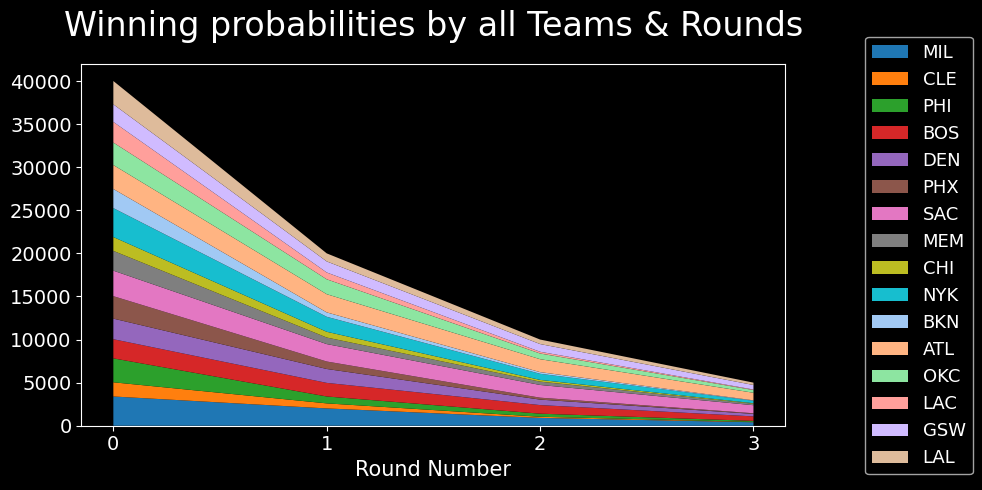

In [78]:
# check that a team's wins should get less and less in later rounds
fig = plotting(playoff.rounds)

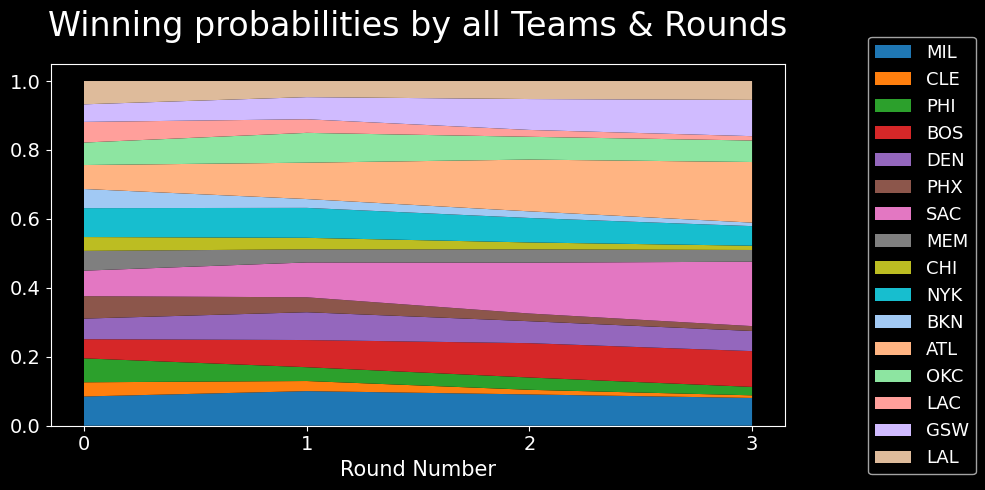

In [79]:
# plot the results: probabilities of winning for all teams at each round
fig = plotting(playoff.rounds_probs)

### ☝️ Observations

1. Based on overall winning probabilities, the top 3 teams are: **Bucks > Lakers > Nuggets**.

2. Based on winning probabilities in the final round, the top 3 teams are: **Bucks > Lakers > Heat**.

3. **Bucks** has a much higher overall chance of winning, if it can get through the early rounds.

4. If we were the **Lakers**, we would avoid the **Bucks**; if we were the **Heat** or **Nuggets**, we would avoid both the **Bucks** and **Lakers**.

### 🌗 Results Comparison (actual 2019-2020 NBA playoff results)

In the actual 2019-2020 playoff, **Bucks** had lost to **Toronto Raptors** narrowly (3-4) at the 1st round. Lakers had, as we predicted, beat both **Nuggets** and **Heat** in the last two rounds and became the champion. These are mostly consistent with our model's predictions given the above observations. And since our model have not seen the 2019-2020 playoff data, it didn't "cheat" to get the results.

### 🤔 Debug: Why Raptors was able to beat Bucks?

From our observations, though Bucks' chances of winning in the early rounds are less than in later rounds,it still is much better than Raptors, how did Bucks lose? One hypothesis is that a strong team(e.g., Bucks), when facing particular type of opponent(e.g., Raptors), may become weaker. To comfirm this hypothesis, we can check the performance of Bucks when up against Raptors in our data.

In [ ]:
# extract games played by Bucks and Raptors

df_br_1 = df.loc[(df['HOME_TEAM_ID'] == 'Bucks') & (df['VISITOR_TEAM_ID'] == 'Raptors')].reset_index(drop=True)
df_br_2 = df.loc[(df['HOME_TEAM_ID'] == 'Raptors') & (df['VISITOR_TEAM_ID'] == 'Bucks')].reset_index(drop=True)


In [ ]:
print('Bucks won {} out of {} when being the home team'.format(
    sum(df_br_1['HOME_TEAM_WINS']), df_br_1.shape[0])) 
print('Bucks won {} out of {} when being the away team'.format(
    df_br_2.shape[0] - sum(df_br_2['HOME_TEAM_WINS']), df_br_2.shape[0])) 

Bucks won 18 out of 35 when being the home team
Bucks won 16 out of 36 when being the away team


In [ ]:
# bucks against Rapters
print("Bucks' chance of winning against Raptors: ", (18 + 16) /(35 + 36))

Bucks' chance of winning against Raptors:  0.4788732394366197


☝️The above explains why Bucks lost: It has little less than random chance of winning against Raptors. In sum, when we train the win/loss classifier, we should take into account which teams are competing as well!

## 🙂 Improvements

1. **Use more and better features**: Powerful simulations usually have more variables to cover more scenarios of the playoff. Using player level statistics is one way to go.

2. **Use better win/loss model**: Our trained SVM Discriminator only has about 70%+ accuracy, it is sufficient but nowhere near perfect. Improvements can be achieved by adding more data features or using a more powerful model such as Neural Network or ensemble model.

3. **Do better at distribution fitting**: In the projects, we used only a handful of distributions to speed up the fitting. To reduce the fitting errors, we can use more complex distributions. The lower the fitting error, the more realistic the samples we can generate.

4. **Run more simulations**: Should we have more variables to account for in our win/loss Discriminator, we need to run more simulations to get the precise probabilities.